### <span style="color:orange"> Install CUDA (GPU drivers from NVIDIA) </span>

- import Pkg; Pkg.add("CUDA");

In [1]:
#import Pkg; Pkg.add("CUDA");
using CUDA

#### By default, Flux will run the checks on your system to see if it can support GPU functionality. You can check if Flux identified a valid GPU setup by typing the following:

In [2]:
CUDA.functional() #check if Flux can find your GPU

false

#### you need to **->move<-** <u>model weights</u> and <u>data</u> to the GPU and Flux will handle it.

- you need to tell Flux that the weights and the data need to go to the GPU to be used in the computation by the GPU

In [5]:
using Flux, Statistics, ProgressMeter
using Plots 
using StatsBase, Random

## <span style="color:orange"> Keyword `gpu` is a function to put models and data onto the GPU </span>

- Float32 is the typical single precision on GPUs

In [6]:
using RDatasets
iris = dataset("datasets", "iris");

In [7]:
typeof(iris)
display( iris[1:3,:])

Row,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa


In [8]:
features = iris[:,1:4]
features = Matrix{Float32}(features) 
println( typeof( features ) )
targets = iris[:,5];

Matrix{Float32}


In [9]:
length( unique( iris[:,end] ) )

3

In [10]:
length( iris[:,end] )

150

In [28]:
odd_inds = findall( mod.(1:150,2) .== 1)
even_inds = findall( mod.(1:150,2) .== 0);

In [29]:
x_train , x_test = features[odd_inds,:] , features[even_inds,:];
y_train , y_test = targets[odd_inds] , targets[even_inds];
println( "x_train size before ", size(x_train) )
x_train = x_train'
x_test = x_test'
println( "x_train size after ", size(x_train) )

x_train size before (75, 4)
x_train size after (4, 75)


In [30]:
#we need to make 1-hot encoding of the categorical values
species = unique( iris[:,end] )
y_train = Flux.onehotbatch( y_train , species )
display( size(y_train) )
y_test = Flux.onehotbatch( y_test , species )

(3, 75)

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

In [31]:
#put onto the GPU
species |> gpu
x_train |> gpu
x_test |> gpu
y_train |> gpu
y_test |> gpu

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

    
- if a GPU is -not- present it will do nothing, it runs on the GPU if the library CUDA.jl loads successfully 
- this function moves data to the GPU from the CPU space  
                    
![by Damien Benveniste ](./cpugputpu.jpg)

(TPUs are not recommended to sequential models like LSTMs and they require longer runs to derive benefit over the GPU)

In [51]:
#make a model for predicting the species (categorical output)
model_iris = Chain( Dense( 4=>8, relu ) , Dense( 8=>3 ) , softmax ) |> gpu

Chain(
  Dense(4 => 8, relu),                  # 40 parameters
  Dense(8 => 3),                        # 27 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 67 parameters, 524 bytes.

### <span style="color:orange"> The data and model is brought back from the GPU to the CPU with the function `cpu` </span>

- if the data has been moved to the GPU it is necessary to run `cpu` in order to do things like plot the data

In [52]:
#put back onto the CPU
species |> gpu
x_train |> cpu
x_test |> cpu
y_train |> cpu
y_test |> cpu

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

In [53]:
println( "model output = " , model_iris( x_train[:,1] ) )
println( "category output predicted ('one-cold') = " , Flux.onecold( model_iris(x_train[:,1]), species ) )
println( "true output label = " , Flux.onecold( y_train[:,1], species ) )
#try out the cross entropy
println( "cross entropy of prediction and target = " , Flux.crossentropy( model_iris( x_train[:,1] ) , y_train[:,1] ) )
println( "cross entropy of predictions and multiple targets = " , Flux.crossentropy( model_iris( x_train[:,1:20] ) , y_train[:,1:20] ) )
hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "init accuracy = ", accuracy , "%")

model output = Float32[0.31751534, 0.5245969, 0.15788765]
category output predicted ('one-cold') = versicolor
true output label = setosa
cross entropy of prediction and target = 1.1472287
cross entropy of predictions and multiple targets = 1.1568553
init accuracy = 33.333333333333336%


In [54]:
#put back onto the GPU
species |> gpu
x_train |> gpu
x_test |> gpu
y_train |> gpu
y_test |> gpu

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

In [55]:
#pack the data and put onto the gpu
data = Flux.DataLoader( (x_train, y_train) , batchsize=20 , shuffle=true ) |> gpu

MLUtils.DataLoader{Tuple{LinearAlgebra.Adjoint{Float32, Matrix{Float32}}, OneHotArrays.OneHotMatrix{UInt32, 3, Vector{UInt32}}}, Random._GLOBAL_RNG, Val{nothing}}((Float32[5.1 4.7 … 6.3 6.2; 3.5 3.2 … 2.5 3.4; 1.4 1.3 … 5.0 5.4; 0.2 0.2 … 1.9 2.3], Bool[1 1 … 0 0; 0 0 … 0 0; 0 0 … 1 1]), 20, false, true, true, false, Val{nothing}(), Random._GLOBAL_RNG())

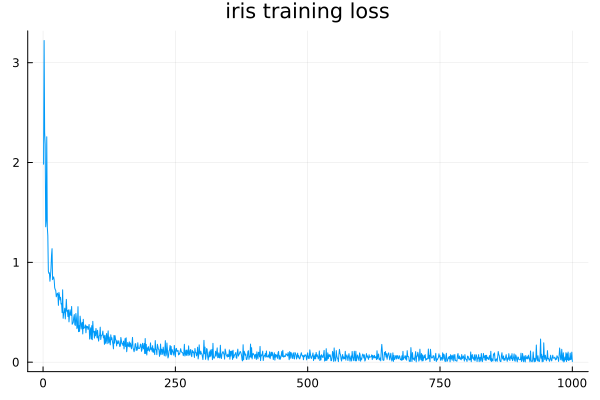

In [59]:
#train the parameters to predict iris
model_iris = Chain( Dense( 4=>8, relu ) , Dense( 8=>3 ) , softmax ) |> gpu
opt = Flux.setup( Flux.Adam(0.01) , model_iris ) |> gpu
losses = []
for epoch in 1:250
    for data_tmp in data    
        #get the gradients
        loss_tmp, grads = Flux.withgradient(model_iris) do model
            y_hat = model(data_tmp[1])
            Flux.crossentropy(y_hat,data_tmp[2])
        end
        Flux.update!(opt, model_iris, grads[1])
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
end
p1 = plot( losses , title="iris training loss" , legend=false )
#savefig("./p1.png") #save the plot in the current directory
display(p1)

In [61]:
model_iris |> cpu
species |> cpu
x_train |> cpu
x_test |> cpu
y_train |> cpu
y_test |> cpu

hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris train accuracy = ", accuracy , "%" )

hits = Flux.onecold( model_iris( x_test ) , species ) .== Flux.onecold( y_test , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris test accuracy = ", accuracy , "%" )

Iris train accuracy = 98.66666666666667%
Iris test accuracy = 96.0%


## <span style="color:orange"> Try the same thing but modify only the activation function in the second layer from identity to become sigmoid </span>

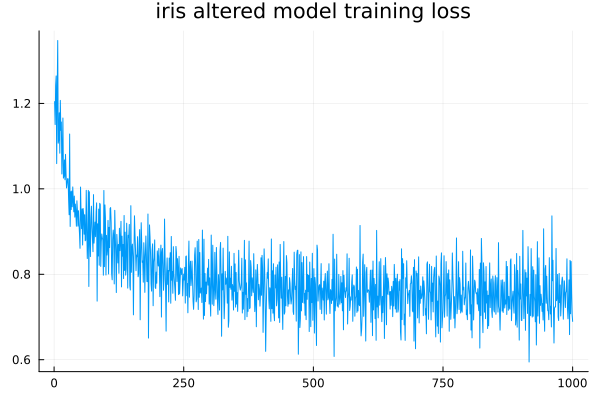

In [67]:
#train the parameters to predict iris
model_iris2 = Chain( Dense( 4=>8, relu ) , Dense( 8=>3 , sigmoid ) , softmax ) |> gpu
opt = Flux.setup( Flux.Adam(0.01) , model_iris2 ) |> gpu
losses = []
for epoch in 1:250
    for data_tmp in data    
        #get the gradients
        loss_tmp, grads = Flux.withgradient(model_iris2) do model
            y_hat = model(data_tmp[1])
            Flux.crossentropy(y_hat,data_tmp[2])
        end
        Flux.update!( opt , model_iris2 , grads[1] )
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
end
p1 = plot( losses , title="iris altered model training loss" , legend=false )
#savefig("./p1.png") #save the plot in the current directory
display(p1)

In [68]:
model_iris |> cpu
species |> cpu
x_train |> cpu
x_test |> cpu
y_train |> cpu
y_test |> cpu

hits = Flux.onecold( model_iris2( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris train accuracy = ", accuracy , "%" )

hits = Flux.onecold( model_iris2( x_test ) , species ) .== Flux.onecold( y_test , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris test accuracy = ", accuracy , "%" )

Iris train accuracy = 66.66666666666667%
Iris test accuracy = 66.66666666666667%


In [75]:
#import Pkg; Pkg.add("MLDatasets")
#import Pkg; Pkg.add("ImageInTerminal")
#import Pkg; Pkg.add("ImageShow")
#import Pkg; Pkg.add("Images")
#import Pkg; Pkg.add("ImageIO")
#import Pkg; Pkg.add("ImageMagick")
using ImageShow, Images, ImageInTerminal
using MLDatasets

In [76]:
train_x_raw, train_y_raw = MNIST(split = :train)[:]
test_x_raw,  test_y_raw  = MNIST(split = :test)[:];
println( "train_x_raw size = $(size(train_x_raw)), train_y_raw size = $(size(train_y_raw))")
display( train_y_raw[1:5] )

train_x_raw size = (28, 28, 60000), train_y_raw size = (60000,)


5-element Vector{Int64}:
 5
 0
 4
 1
 9

[5, 0, 4, 1, 9]


,,,,

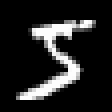
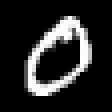
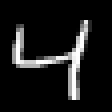
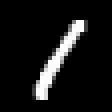
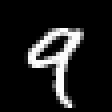

In [77]:
println( [ train_y_raw[ ii ] for ii in 1:5 ] )
[ convert2image(MNIST, train_x_raw[ : , : , ii ] ) for ii in 1:5 ]

[5, 0, 4, 1, 9]


,,,,

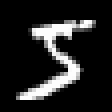
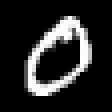
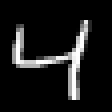
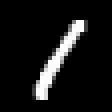
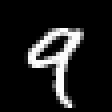

In [78]:
#color view needs the transpose since the x and y are flipped
println( [ train_y_raw[ ii ] for ii in 1:5 ] )
[ colorview( Gray , train_x_raw[ : , : , ii ]' ) for ii in 1:5 ]

In [79]:
#make the data from matrix to vector
train_x = Flux.flatten(train_x_raw)
test_x = Flux.flatten(test_x_raw)
println( "size of train_x = $(size(train_x))")
println( "28 x 28 = $(28*28)")

size of train_x = (784, 60000)
28 x 28 = 784


In [80]:
train_y = Flux.onehotbatch( train_y_raw , 0:9 )
test_y  = Flux.onehotbatch( test_y_raw , 0:9 )
println( "size of train_y = $(size(train_y))" )
println( "unique train_y_raw = $(unique(train_y_raw))" )
display( train_y[ : , 1:3 ] )

size of train_y = (10, 60000)
unique train_y_raw = [5, 0, 4, 1, 9, 2, 3, 6, 7, 8]


10×3 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  1
 1  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅

In [81]:
model_digits = Chain( Dense( 28*28=>60 , sigmoid) , Dense( 60=>32 , relu ) , Dense( 32=>10 , relu ) , softmax ) 

Chain(
  Dense(784 => 60, σ),                  # 47_100 parameters
  Dense(60 => 32, relu),                # 1_952 parameters
  Dense(32 => 10, relu),                # 330 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 49_382 parameters, 193.273 KiB.

In [82]:
#test the model at init ( untrained ) on 1 image
model_digits( train_x[:,1] )

10-element Vector{Float32}:
 0.07256387
 0.21996251
 0.07256387
 0.07256387
 0.07256387
 0.12461349
 0.07256387
 0.07256387
 0.11103663
 0.10900413

In [83]:
#test the model at init ( untrained ) on 3 images
model_digits( train_x[:,1:3] )

10×3 Matrix{Float32}:
 0.0725639  0.0722208  0.074063
 0.219962   0.253218   0.243183
 0.0725639  0.0722208  0.074063
 0.0725639  0.0722208  0.074063
 0.0725639  0.0722208  0.074063
 0.124613   0.121969   0.124022
 0.0725639  0.0722208  0.074063
 0.0725639  0.0722208  0.074063
 0.111037   0.0993615  0.0944252
 0.109004   0.0921277  0.0939919

In [88]:
#convert outputs to labels via one cold
Flux.onecold( model_digits(train_x[:,1]) , 0:9 )

1

In [89]:
#initial accuracy of untrained model
model_digits( train_x[:,1:3] )

10×3 Matrix{Float32}:
 0.0725639  0.0722208  0.074063
 0.219962   0.253218   0.243183
 0.0725639  0.0722208  0.074063
 0.0725639  0.0722208  0.074063
 0.0725639  0.0722208  0.074063
 0.124613   0.121969   0.124022
 0.0725639  0.0722208  0.074063
 0.0725639  0.0722208  0.074063
 0.111037   0.0993615  0.0944252
 0.109004   0.0921277  0.0939919

In [90]:
Flux.onecold( model_digits(train_x[:,1:3]) , 0:9 )

3-element Vector{Int64}:
 1
 1
 1

7


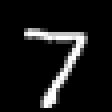

In [98]:
#look at the label in onecold and the corresponding image
println( Flux.onecold( test_y[:,1] , 0:9 ) )
colorview( Gray , test_x_raw[ : , : , 1 ]' )

In [84]:
data_digits = Flux.DataLoader( (train_x, train_y) , batchsize=5 , shuffle=true )

MLUtils.DataLoader{Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, 10, Vector{UInt32}}}, Random._GLOBAL_RNG, Val{nothing}}((Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 1 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 0 0]), 5, false, true, true, false, Val{nothing}(), Random._GLOBAL_RNG())

In [148]:

data_digits |> gpu
model_digits = Chain( Dense( 28*28=>60 , sigmoid) , Dense( 60=>32 , relu ) , Dense( 32=>10 , relu ) , softmax ) |> gpu
opt = Flux.setup( Flux.Adam(0.01) , model_digits );

losses = []
for epoch in 1:15
    
    #make the step size smaller after a certain point of time
    if( epoch == 10 ) Flux.adjust!( opt , 0.001 ) end
    
    for ( x , y ) in data_digits    
        
        loss_tmp, grads = Flux.withgradient( model_digits ) do model                        
                
            y_hat = model( x )
            loss = Flux.crossentropy( y_hat , y )
            return loss
            
        end     
        Flux.update!( opt , model_digits , grads[1] )
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
#     break
end
p1 = plot( losses , title="MNIST training loss" , legend=false , size=(600,150) )
savefig(p1,"p1.png")
display(p1)

In [149]:

test_y_labels = Flux.onecold( test_y , 0:9 )

test_res = model_digits( test_x )
test_res_labels = Flux.onecold( test_res , 0:9 )
println( size( test_res_labels ) )
println( size( test_y_labels ) )

model_digits |> cpu
println( "accuracy = ", 100 * (sum( test_res_labels .== test_y_labels ) / length( test_y_labels ) ) , "%" )

(10000,)
(10000,)
accuracy = 29.28%


[LeNet5](https://en.wikipedia.org/wiki/LeNet) 

- The original used the sigmoid but modern versions use the RELU
- [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) . This is LeNet5 original paper by Yann LeCunn and others.
- This example demonstrates Flux’s Convolution and pooling layers

In [249]:
function LeNet5(; imgsize=(28,28,1), nclasses=10) 
    out_conv_size = (imgsize[1]÷4 - 3, imgsize[2]÷4 - 3, 16)
    println(prod(out_conv_size))
    
    return Chain(
            Conv((5, 5), imgsize[end]=>6, relu) , 
            MaxPool((2, 2)), 
            Conv((5, 5), 6=>16, relu),
            MaxPool((2, 2)),
            Flux.flatten,
            Dense(prod(out_conv_size) => 120, relu), 
            Dense(120 => 84, relu), 
            Dense(84 => 10)
          )
end
model = LeNet5()

256


Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.867 KiB.

In [252]:
tmp = reshape(train_x_raw[:,:,1], (28, 28, 1, :)) # WHCN
println( size( tmp ) )
println( model( tmp ) )

(28, 28, 1, 1)
Float32[-0.31671813; 0.15171582; 0.123066336; 0.07720645; -0.20839876; 0.08841818; -0.036416724; 0.2922087; -0.16947283; 0.18164803;;]


In [254]:
tmp = reshape(train_x_raw[:,:,1:3], (28, 28, 1, :)) # WHCN
println( size( tmp ) )
display( model( tmp ) )

(28, 28, 1, 3)


10×3 Matrix{Float32}:
 -0.316718   -0.34693    -0.242617
  0.151716    0.249776    0.097688
  0.123066    0.134961    0.109502
  0.0772064   0.201911    0.0469635
 -0.208399   -0.0760325  -0.00375285
  0.0884182   0.148455    0.137939
 -0.0364167  -0.041658   -0.0926447
  0.292209    0.358355    0.260462
 -0.169473   -0.327026   -0.320252
  0.181648    0.196239    0.116028

In [258]:
tmp = [ Flux.unsqueeze( Float32.(train_x_raw[:,:,ii]), 3 ) for ii in 1:5 ]
tmp_batch = Flux.batch( tmp )
println( size( tmp ) )
println( size( tmp_batch ) )
model( tmp_batch )

(5,)
(28, 28, 1, 5)


10×5 Matrix{Float32}:
 -0.316718   -0.34693    -0.242617   -0.179293    -0.4214
  0.151716    0.249776    0.0976881   0.0420827    0.0559863
  0.123066    0.134961    0.109502   -0.0364133    0.000423443
  0.0772065   0.201911    0.0469635   0.11687     -0.131159
 -0.208399   -0.0760326  -0.0037528  -0.111978    -0.0787276
  0.0884182   0.148455    0.137939    0.041221     0.224824
 -0.0364168  -0.041658   -0.0926447  -0.00288389   0.00410175
  0.292209    0.358355    0.260462    0.335358     0.315024
 -0.169473   -0.327026   -0.320252   -0.285828    -0.297492
  0.181648    0.196239    0.116028    0.221269     0.231964

In [151]:
use_cuda = CUDA.functional()

device = ""
if use_cuda
    device = gpu
    @info "Training on GPU"
else
    device = cpu
    @info "Training on CPU"
end

┌ Info: Training on CPU
└ @ Main In[151]:9


In [154]:
function LeNet5(; imgsize=(28,28,1), nclasses=10) 
    out_conv_size = (imgsize[1]÷4 - 3, imgsize[2]÷4 - 3, 16)
    
    return Chain(
            Conv((5, 5), imgsize[end]=>6, relu),
            MaxPool((2, 2)),
            Conv((5, 5), 6=>16, relu),
            MaxPool((2, 2)),
            flatten,
            Dense(prod(out_conv_size), 120, relu), 
            Dense(120, 84, relu), 
            Dense(84, nclasses)
          )
end


LeNet5 (generic function with 1 method)

In [155]:
loss(ŷ, y) = logitcrossentropy(ŷ, y)

loss (generic function with 1 method)

In [156]:
function eval_loss_accuracy(data, model, device)
    l = 0f0
    acc = 0
    ntot = 0
    for (x, y) in data
        x, y = x |> device, y |> device
        ŷ = model(x)
        l += loss(ŷ, y) * size(x)[end]        
        acc += sum(Flux.onecold(ŷ |> cpu) .== Flux.onecold(y |> cpu))
        ntot += size(x)[end]
    end
    return (loss = l/ntot , acc = acc/ntot*100 )
end

eval_loss_accuracy (generic function with 1 method)

In [157]:
model = LeNet5() |> device

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  DataFrames.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.867 KiB.

In [ ]:
opt = Flux.setup( Flux.Adam(0.001) , model ) 
# if args.λ > 0 ## add weight decay, equivalent to L2 regularization
#     opt = Flux.Optimise.Optimiser(Flux.Optimize.WeightDecay(args.λ), opt)
# end

In [165]:
data_digits = Flux.DataLoader( (train_x, train_y) , batchsize=5 , shuffle=true )

function get_data()
    xtrain, ytrain = MLDatasets.MNIST(:train)[:]
    xtest, ytest = MLDatasets.MNIST(:test)[:]

    xtrain = reshape(xtrain, 28, 28, 1, :)
    xtest = reshape(xtest, 28, 28, 1, :)

    ytrain, ytest = Flux.onehotbatch(ytrain, 0:9), Flux.onehotbatch(ytest, 0:9)

    train_loader = Flux.DataLoader((xtrain, ytrain), batchsize=125, shuffle=true)
    test_loader = Flux.DataLoader((xtest, ytest),  batchsize=125)
    
    return train_loader, test_loader
end
train_loader, test_loader = get_data();

In [166]:
data_digits |> gpu

losses = []
for epoch in 1:1
        
    for ( x , y ) in train_loader    
        
        println("size x=$(size(x)) size y=$(size(y))")
        
        loss_tmp, grads = Flux.withgradient( model ) do model                        
            println("ok1")    
            y_hat = model( x )
            loss = Flux.logitcrossentropy( y_hat , y ) #logitcrossentropy since softmax is not applied at the end of the model
            return loss
            
        end     
        Flux.update!( opt , model , grads[1] )
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
#     break
end
p1 = plot( losses , title="LeNet training loss" , legend=false , size=(600,150) )
savefig(p1,"p1.png")
display(p1)

size x=(28, 28, 1, 125) size y=(10, 125)
ok1


LoadError: MethodError: no method matching flatten(::Array{Float32, 4})
[0mClosest candidates are:
[0m  flatten([91m::AbstractDataFrame[39m, [91m::Union{Colon, Regex, AbstractString, Signed, Symbol, Unsigned, AbstractVector, All, Between, Cols, InvertedIndex}[39m) at ~/.julia/packages/DataFrames/bza1S/src/abstractdataframe/abstractdataframe.jl:2541

In [ ]:
for epoch in 1:args.epochs
        @showprogress for (x, y) in train_loader
            x, y = x |> device, y |> device
            gs = Flux.gradient(ps) do
                    ŷ = model(x)
                    loss(ŷ, y)
                end

            Flux.Optimise.update!(opt, ps, gs)
        end

In [177]:
# We set default values for the arguments for the function `train`:

Base.@kwdef mutable struct Args
    η = 3e-4             ## learning rate
    λ = 0                ## L2 regularizer param, implemented as weight decay
    batchsize = 128      ## batch size
    epochs = 10          ## number of epochs
    seed = 0             ## set seed > 0 for reproducibility
    use_cuda = true      ## if true use cuda (if available)
end

LoadError: invalid redefinition of constant Args

In [188]:

using Flux.Optimise: Optimiser, WeightDecay
#using Flux: onehotbatch, onecold, flatten
using Statistics, Random
using Logging: with_logger
using TensorBoardLogger: TBLogger, tb_overwrite, set_step!, set_step_increment!
import MLDatasets
using CUDA

function get_data()
    xtrain, ytrain = MLDatasets.MNIST(:train)[:]
    xtest, ytest = MLDatasets.MNIST(:test)[:]

    xtrain = reshape(xtrain, 28, 28, 1, :)
    xtest = reshape(xtest, 28, 28, 1, :)

    ytrain, ytest = Flux.onehotbatch(ytrain, 0:9), Flux.onehotbatch(ytest, 0:9)

    train_loader = Flux.DataLoader((xtrain, ytrain), batchsize=22, shuffle=true)
    test_loader = Flux.DataLoader((xtest, ytest),  batchsize=22)
    
    return train_loader, test_loader
end

function LeNet5(; imgsize=(28,28,1), nclasses=10) 
    out_conv_size = (imgsize[1]÷4 - 3, imgsize[2]÷4 - 3, 16)
    
    return Chain(
            Conv((5, 5), imgsize[end]=>6, relu), MaxPool((2, 2)), Conv((5, 5), 6=>16, relu), MaxPool((2, 2)),
            flatten,
            Dense(prod(out_conv_size), 120, relu), Dense(120, 84, relu), Dense(84, nclasses)
          )
end

loss(ŷ, y) = Flux.logitcrossentropy(ŷ, y)


loss (generic function with 1 method)

In [196]:
function train(; kws...)
#     args = Args(; kws...)
#     args.seed > 0 && Random.seed!(args.seed)
    use_cuda = CUDA.functional()
    
    if use_cuda
        device = gpu
    else
        device = cpu
    end

    ## DATA
    train_loader, test_loader = get_data()

    ## MODEL AND OPTIMIZER
    model = LeNet5() |> device
    
    opt = Flux.setup( Flux.Adam(0.001) , model ) 
    
    ## TRAINING
    for epoch in 1:1
        for (x, y) in train_loader
            x, y = x |> device, y |> device
            gs = Flux.gradient(model) do
                    ŷ = model(x)
                    loss(ŷ, y)
                end

            Flux.update!(opt, model, gs)
        end        
    end
    
end


train()

LoadError: MethodError: no method matching (::var"#141#142"{Chain{Tuple{Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}, Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}, typeof(flatten), Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}})(::Chain{Tuple{Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}, Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}, typeof(flatten), Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}})
[0mClosest candidates are:
[0m  (::var"#141#142")() at In[196]:25

In [210]:
using Flux, Flux.Data.MNIST, CUDA, Statistics

labels = MNIST.labels();
images = MNIST.images();

xs = [Flux.unsqueeze(Float64.(img), 3) for img in images[1:5000]]
ys = [Flux.onehot(label, 0:9) for label in labels[1:5000]]

model = Chain(Conv((3, 3), 1=>16, pad=(1,1), relu),
        MaxPool((2,2)),
        Conv((3, 3), 16=>32, pad=(1,1), relu),
        MaxPool((2,2)),
        Conv((3, 3), 32=>32, pad=(1,1), relu),
        MaxPool((2,2)),
        flatten,
        Dense(288,10),
        softmax) |> gpu

L(x, y) = Flux.logitcrossentropy(model(x), y)
opt = Descent(0.1)
databatch = (Flux.batch(xs), Flux.batch(ys)) |> gpu
Flux.train!(L, params(model), Iterators.repeated(databatch, 10), opt,

test_images = MNIST.images(:test)
test_labels = MNIST.labels(:test)
txs = [Flux.unsqueeze(Float64.(img), 3) for img in test_images[1:10]]
tys = [Flux.onehot(label, 0:9) for label in test_labels[1:10]]

test_set = (Flux.batch(txs), Flux.batch(tys)) |> gpu

accuracy(x, y, model) = mean(Flux.onecold(cpu(model(x))) .== Flux.onecold(cpu(y)))
acc = accuracy(test_set..., model)


LoadError: UndefVarError: MNIST not defined